<a href="https://colab.research.google.com/github/DariusTheGeek/Football-Predictions-Mchezopesa-Ltd-Part-2/blob/master/Lasso%2C_Ridge_and_ElasticNet_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Research Question.
Predict the rank of a team

## Metric for Success
The Root Mean Squared Error will be used to measure the performace of the model.

In [0]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
import requests
from io import StringIO
import datetime as dt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [0]:
# Creating a function to read a csv file shared via google drive
def read_google_csv(url):
  url = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
  csv_raw = requests.get(url).text
  csv = StringIO(csv_raw)
  return csv

In [3]:
# Loading the data the fifa ranking dataset into a pandas dataframe
# Previewing the first five rows of the dataset
#
fifa_ranking_dataset_url = 'https://drive.google.com/file/d/1sMiLf1tsXVb4jbgKaHgSjZ6Js0ev7dIf/view?usp=sharing'

ranking = pd.read_csv(read_google_csv(fifa_ranking_dataset_url))
ranking.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [5]:
# Previewing some information of the fifa ranking dataset
#
ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57793 entries, 0 to 57792
Data columns (total 16 columns):
rank                       57793 non-null int64
country_full               57793 non-null object
country_abrv               57793 non-null object
total_points               57793 non-null float64
previous_points            57793 non-null int64
rank_change                57793 non-null int64
cur_year_avg               57793 non-null float64
cur_year_avg_weighted      57793 non-null float64
last_year_avg              57793 non-null float64
last_year_avg_weighted     57793 non-null float64
two_year_ago_avg           57793 non-null float64
two_year_ago_weighted      57793 non-null float64
three_year_ago_avg         57793 non-null float64
three_year_ago_weighted    57793 non-null float64
confederation              57793 non-null object
rank_date                  57793 non-null object
dtypes: float64(9), int64(3), object(4)
memory usage: 7.1+ MB


In [6]:
# Previewing some statistical summaries of the fifa ranking dataset
#
ranking.describe()

,rank,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted
count,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000
mean,101.628086,122.068637,332.302926,-0.009897,61.798602,61.798602,61.004602,30.502377,59.777462,17.933277,59.173916,11.834811
std,58.618424,260.426863,302.872948,5.804309,138.014883,138.014883,137.688204,68.844143,136.296079,40.888849,135.533343,27.106675
min,1.000000,0.000000,0.000000,-72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,0.000000,56.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,101.000000,0.000000,272.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,152.000000,92.790000,525.000000,1.000000,32.250000,32.250000,26.660000,13.330000,21.500000,6.450000,21.250000,4.250000
max,209.000000,1775.030000,1920.000000,92.000000,1158.660000,1158.660000,1169.570000,584.790000,1159.710000,347.910000,1200.770000,240.150000


In [7]:
# Checking for missing values of the fifa ranking dataset
#
ranking.isnull().sum()

rank                       0
country_full               0
country_abrv               0
total_points               0
previous_points            0
rank_change                0
cur_year_avg               0
cur_year_avg_weighted      0
last_year_avg              0
last_year_avg_weighted     0
two_year_ago_avg           0
two_year_ago_weighted      0
three_year_ago_avg         0
three_year_ago_weighted    0
confederation              0
rank_date                  0
dtype: int64

In [8]:
# Checking for duplicates
#
ranking.duplicated().any()

True

In [0]:
# Removing duplicates

ranking.drop_duplicates(keep='first', inplace = True)

In [5]:
# Checking whether the duplicates have been removed
#
ranking.duplicated().any()

False

In [0]:
# Changing the date column to datetime object
#
ranking.rank_date = pd.to_datetime(ranking.rank_date)

# Creating a year and month column from the datetime object
#
ranking['year'] = ranking.rank_date.dt.year
ranking['month'] = ranking.rank_date.dt.month

In [7]:
# Checking the unique items in the ranking dataset
#
for col in ['country_full', 'confederation', 'year', 'rank']:
  print(col)
  print(ranking[col].nunique())
  print(ranking[col].unique())
  print('\n')

country_full
216
['Germany' 'Italy' 'Switzerland' 'Sweden' 'Argentina'
 'Republic of Ireland' 'Russia' 'Brazil' 'Norway' 'Denmark' 'England'
 'France' 'Spain' 'Mexico' 'RCS' 'Netherlands' 'Nigeria' 'Belgium'
 'Colombia' 'Poland' 'Romania' 'Uruguay' 'Portugal' 'Cameroon' 'Zambia'
 'Egypt' 'Wales' 'USA' "CÃ´te d'Ivoire" 'Scotland' 'Tunisia' 'Greece'
 'Morocco' 'Algeria' 'Ecuador' 'Korea Republic' 'Bulgaria' 'Austria'
 'Costa Rica' 'Northern Ireland' 'Honduras' 'Hungary' 'Japan'
 'Saudi Arabia' 'China PR' 'Canada' 'Finland' 'Ghana' 'Chile' 'Zimbabwe'
 'Qatar' 'Australia' 'Iceland' 'IR Iran' 'United Arab Emirates'
 'Yugoslavia' 'Iraq' 'Senegal' 'Bolivia' 'Kuwait' 'Korea DPR'
 'El Salvador' 'Turkey' 'Gabon' 'Guinea' 'Thailand' 'Paraguay' 'Malawi'
 'Israel' 'Peru' 'Zaire' 'Cyprus' 'Singapore' 'Mali' 'Malaysia' 'Bermuda'
 'Niger' 'Syria' 'Bahrain' 'New Zealand' 'Madagascar' 'Malta' 'Jamaica'
 'Lithuania' 'Trinidad and Tobago' 'Sierra Leone' 'Jordan' 'Kenya'
 'Latvia' 'Yemen' 'Tanzania' 'Alban

## Exploratory Data Analysis

### Bar chart showing games played per confederation

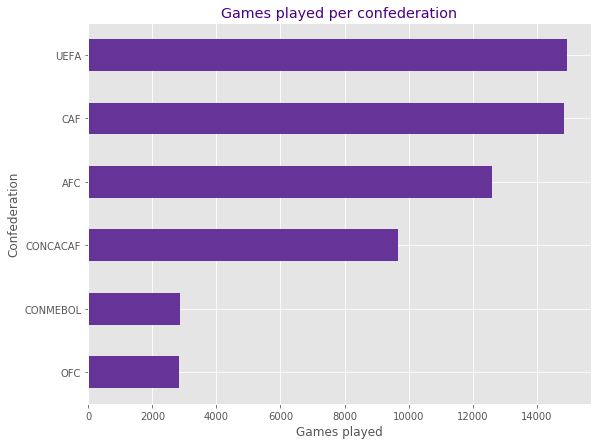

In [8]:
# Creating a dataframe of grouped confederations
#
games_played = ranking.groupby('confederation')['confederation'].count().sort_values(ascending = True)
games_played.plot(kind = 'barh', figsize = (9, 7), color = 'rebeccapurple')
plt.title('Games played per confederation', color = 'indigo')
plt.xlabel('Games played')
plt.ylabel('Confederation')
plt.show()

### Box plots to check for outliers

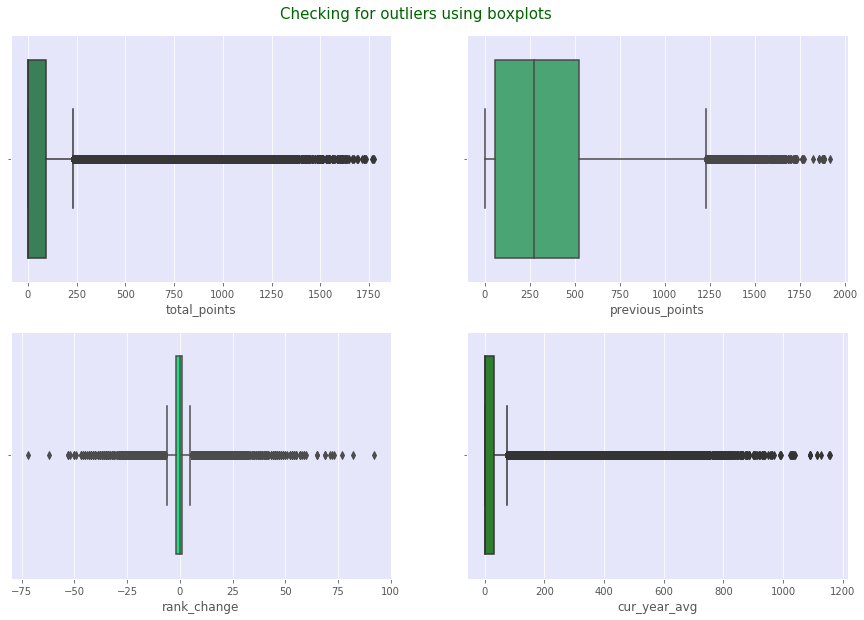

In [9]:
# Creating a list of columns to check for outliers
# Creating a list of colors
#
col_list = ['total_points',	'previous_points',	'rank_change',	'cur_year_avg']
colors = ['seagreen', 'mediumseagreen', 'springgreen', 'forestgreen']

# Plotting boxplots of the col_list columns to check for outliers
#
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
plt.suptitle('Checking for outliers using boxplots', fontsize = 15, y = 0.92, color = 'darkgreen')
for ax, data, column, color in zip(axes.flatten(), ranking, col_list, colors):
  sns.boxplot(ranking[column], ax = ax, color = color)
  ax.set_facecolor('lavender') # Setting the background color to lavender

### Distribution of total and previous points

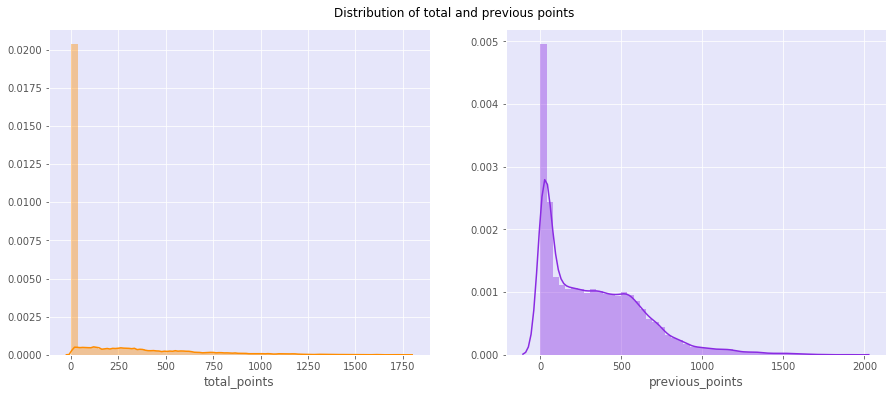

In [15]:
# Using displots to plot distribution of total points and previous points
#
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
plt.suptitle('Distribution of total and previous points', y = 0.93)
for ax, data, column, color in zip(axes.flatten(), ranking, ['total_points',	'previous_points'], ['darkorange', 'blueviolet']):
  sns.distplot(ranking[column], ax = ax, hist = True, color = color)
  ax.set_facecolor('lavender')

### Scatter plots to show relationships between variables

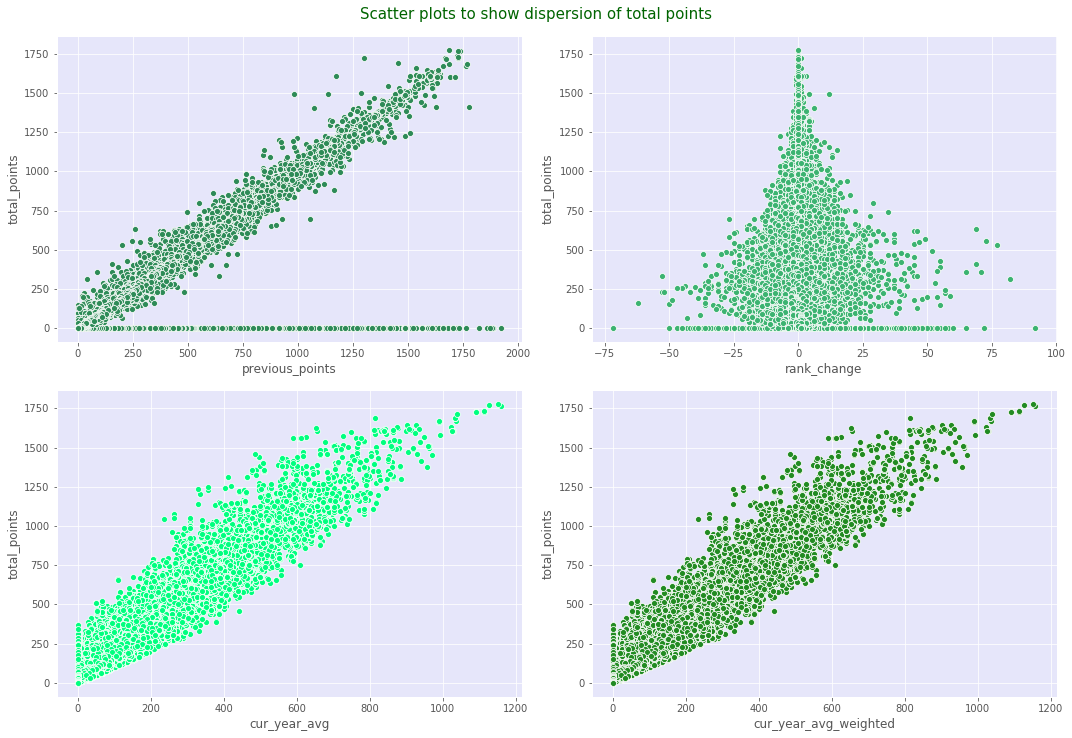

In [16]:
# Plotting scatter plots to show dispersion of total points
# Setting the figure size to 15 by 10
#
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
plt.suptitle('Scatter plots to show dispersion of total points', fontsize = 15, y = 1.02, color = 'darkgreen')
for ax, data, column, color in zip(axes.flatten(), ranking, ['previous_points',	'rank_change',	'cur_year_avg',	'cur_year_avg_weighted'], colors):
  sns.scatterplot(ranking[column], ranking.total_points, ax = ax, color = color)
  ax.set_facecolor('lavender') # Setting the background color to lavender
plt.tight_layout()

### Total points per confederation

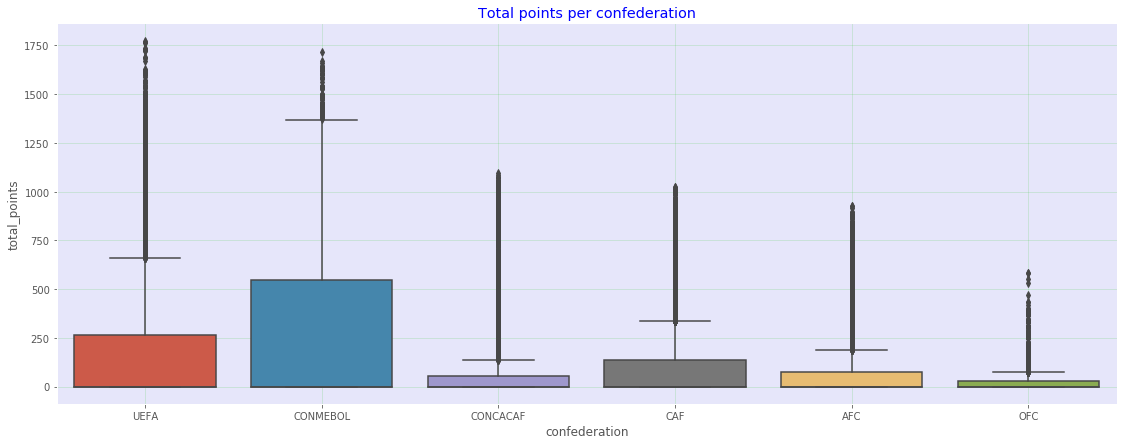

In [17]:

# Plotting boxplots of confederation against total points
#
plt.figure(figsize=(19,7))  # Setting the figure size to 19 by 7
ax = sns.boxplot(y=ranking.total_points,x=ranking.confederation) # Plotting the boxplots for each year
ax.set_facecolor('lavender')
plt.grid(True, color = 'limegreen', alpha = 0.2)
plt.title("Total points per confederation",color='b')
plt.show()

### Average points per year

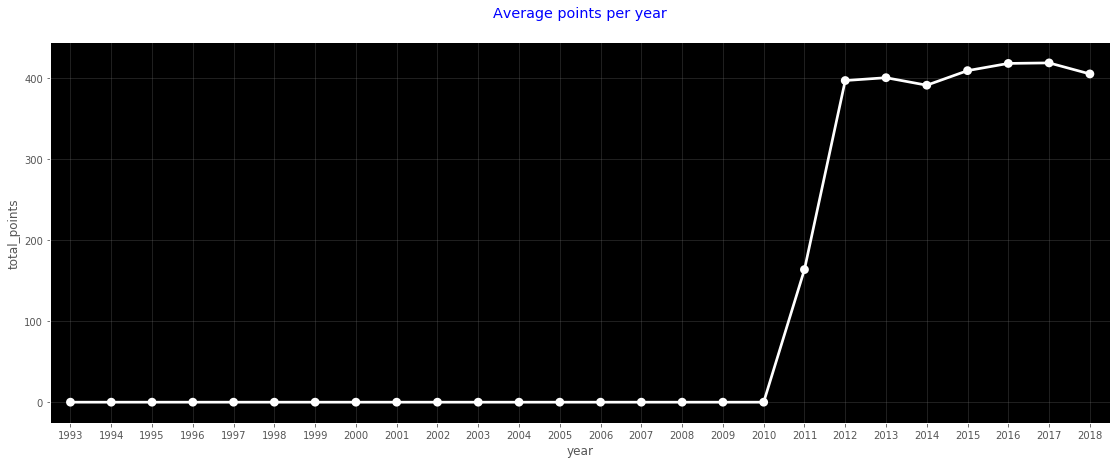

In [18]:
# Creating a dataframe of years and total points
#
points = ranking.groupby('year')['total_points'].mean().reset_index()
points.year = points.year.astype(int) # Changing the datatype of the year column to int

# Setting the figure size of the plot to 19 by 7
#
plt.figure(figsize=(19,7))
ax = sns.pointplot(points.year,points.total_points,color="w") # Plotting a pointplot to show the trend of average goals scored across the years

ax.set_facecolor("k") # setting the background color to black, for contrast
plt.grid(True,color="grey",alpha=.3) # Setting the color of the grid lines to grey and setting the opacity to 0.3
plt.title("Average points per year",color='b', y = 1.05) # Giving the chart a title of color blue
plt.show()

## Checking for multicollinearity
Multicollinearity refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related. We have perfect multicollinearity if, for example as in the equation above, the correlation between two independent variables is equal to 1 or −1

In [19]:
# Displaying the correlations between the variables
#
corrs = ranking.drop('rank_date', axis = 1).corr()
corrs

,rank,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,year,month
rank,1.000000,-0.343937,-0.725821,-0.051695,-0.340039,-0.340039,-0.315499,-0.315499,-0.309206,-0.309206,-0.305445,-0.305444,0.067845,-0.006350
total_points,-0.343937,1.000000,0.531758,0.019430,0.973092,0.973092,0.931494,0.931494,0.915606,0.915606,0.906325,0.906325,0.560462,-0.016380
previous_points,-0.725821,0.531758,1.000000,-0.028756,0.519526,0.519526,0.495539,0.495539,0.483195,0.483195,0.476409,0.476408,0.335695,-0.043469
rank_change,-0.051695,0.019430,-0.028756,1.000000,0.046128,0.046128,-0.015775,-0.015775,-0.004953,-0.004953,-0.000768,-0.000768,0.002231,-0.001358
cur_year_avg,-0.340039,0.973092,0.519526,0.046128,1.000000,1.000000,0.843115,0.843115,0.846445,0.846445,0.839627,0.839627,0.533838,-0.015010
cur_year_avg_weighted,-0.340039,0.973092,0.519526,0.046128,1.000000,1.000000,0.843115,0.843115,0.846445,0.846445,0.839627,0.839627,0.533838,-0.015010
last_year_avg,-0.315499,0.931494,0.495539,-0.015775,0.843115,0.843115,1.000000,1.000000,0.840156,0.840156,0.849770,0.849770,0.531746,-0.016553
last_year_avg_weighted,-0.315499,0.931494,0.495539,-0.015775,0.843115,0.843115,1.000000,1.000000,0.840156,0.840156,0.849770,0.849770,0.531747,-0.016553
two_year_ago_avg,-0.309206,0.915606,0.483195,-0.004953,0.846445,0.846445,0.840156,0.840156,1.000000,1.000000,0.844958,0.844959,0.527019,-0.015407
two_year_ago_weighted,-0.309206,0.915606,0.483195,-0.004953,0.846445,0.846445,0.840156,0.840156,1.000000,1.000000,0.844959,0.844959,0.527019,-0.015407


*The tabe above shows how each variable relates to another. The coefficient of 1 across the diagonal makes sense, as a variable is perfectly correlated to itself. The correlations have been used to compute the VIF (Variance Inflation Factor) value for each variable.The VIF is created by finding the inverse matrix of the correations matrix.*

In [20]:
# Creating a dataframe of the VIF
#
vif_df = pd.DataFrame(np.linalg.inv(corrs.values), index = corrs.index, columns = corrs.columns)
vif_df

,rank,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,year,month
rank,2.915906e+00,-2.052961e-01,2.285671e+00,2.146390e-01,-1.322136e+09,1.328563e+09,-1.184580e+03,1.180019e+03,7.894992e-01,-2.993275e+00,-6.375640e+01,5.607048e+01,-1.236111e+00,-1.589941e-03
total_points,-2.450901e-01,3.872079e+05,-5.156439e-01,-5.380193e+00,7.726059e+11,-7.723155e+11,3.253662e+02,-1.026273e+05,-1.649031e+05,1.040487e+05,2.032967e+03,-4.234544e+04,-4.464782e-01,3.155294e-01
previous_points,2.285214e+00,-5.188466e-01,3.196013e+00,2.250971e-01,9.059096e+09,-9.057252e+09,-1.449394e+03,1.449542e+03,-1.611355e-01,2.767003e-01,-6.081427e+02,6.081847e+02,-1.042871e+00,4.052877e-02
rank_change,2.145509e-01,-5.377713e+00,2.251335e-01,1.032847e+00,1.674228e+09,-1.667178e+09,-1.903351e+02,1.938563e+02,1.482811e+00,-1.559332e+00,2.278988e+01,-2.203174e+01,-8.949255e-02,3.541173e-03
cur_year_avg,-1.200699e+11,-2.480531e+13,-2.779689e+11,-6.330808e+10,3.162019e+24,-3.162019e+24,2.015635e+17,-2.015570e+17,1.441260e+17,-1.441224e+17,-6.687792e+16,6.688051e+16,3.358441e+11,1.868529e+10
cur_year_avg_weighted,1.200699e+11,2.480531e+13,2.779689e+11,6.330808e+10,-3.162019e+24,3.162019e+24,-2.015635e+17,2.015570e+17,-1.441260e+17,1.441224e+17,6.687792e+16,-6.688051e+16,-3.358441e+11,-1.868529e+10
last_year_avg,-1.107915e+03,-4.994124e+04,-2.038093e+03,-2.997965e+02,1.282471e+14,-1.282471e+14,1.533561e+09,-1.533550e+09,2.396316e+04,-1.677287e+04,-1.411558e+07,1.412058e+07,2.420620e+03,2.402483e+02
last_year_avg_weighted,1.108099e+03,-5.241285e+04,2.038131e+03,3.013609e+02,-1.284703e+14,1.284703e+14,-1.533564e+09,1.533580e+09,1.962291e+04,-1.074200e+04,1.411524e+07,-1.410959e+07,-2.420798e+03,-2.403513e+02
two_year_ago_avg,6.857554e+02,-7.061535e+04,1.037809e+03,2.568075e+02,-1.650351e+16,1.650351e+16,-1.057841e+09,1.057860e+09,2.915305e+04,-1.747873e+04,3.540871e+08,-3.540801e+08,-1.191805e+03,-1.259653e+01
two_year_ago_weighted,-6.855892e+02,9.812615e+03,-1.037713e+03,-2.558781e+02,1.650340e+16,-1.650340e+16,1.057841e+09,-1.057845e+09,-3.261276e+03,1.139641e+03,-3.540877e+08,3.540870e+08,1.191617e+03,1.252803e+01


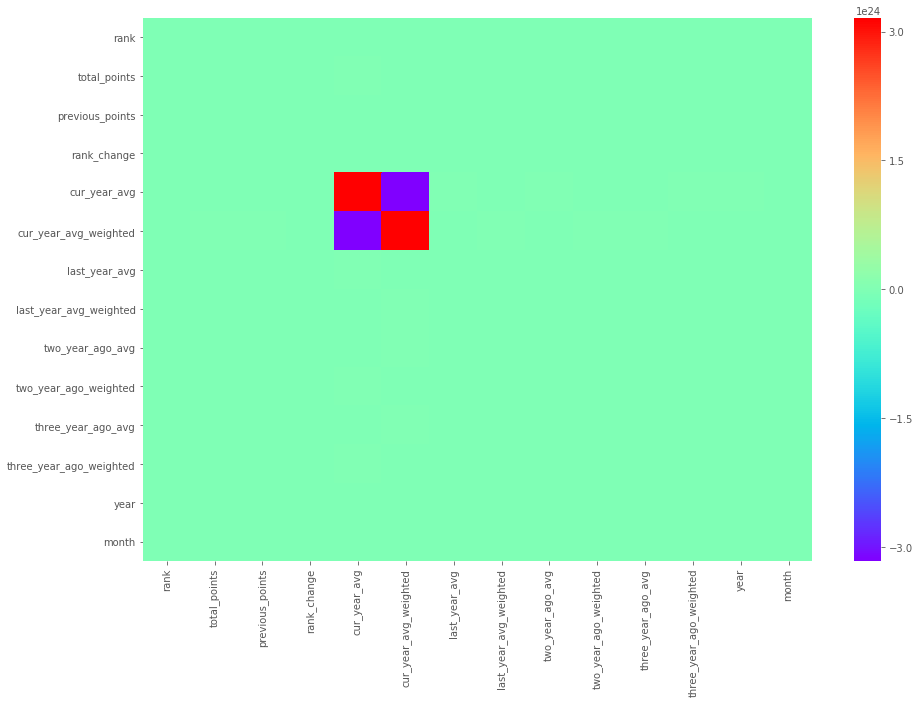

In [21]:
# Creating a heatmap of the vif_df
#
plt.figure(figsize = (15, 10))
sns.heatmap(vif_df, cmap = 'rainbow')
plt.show()

*The VIF score for each variable is found alongside the downwards sloping diagonal. All of this VIF values are under 5, therefore there is no multicollinearity*

## Ridge Regression

### Creating the model

In [22]:
# Creating X and y variables
#
X = ranking.drop(['rank', 'country_abrv', 'rank_date'], axis = 1)
y = ranking.iloc[:, 0:1]

# Encoding categorical variables
#
X = pd.get_dummies(X, drop_first=True)

# Splitting the dataset into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)

# Training the model
#
ridge = Ridge(normalize=True)
ridge.fit(X_train, y_train)

# Making predictions
#
y_pred = ridge.predict(X_test)

# Measuring the accuracy of the model
#
print(f'RMSE of Ridge: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Mean of y: {y.mean()[0]}')

RMSE of Ridge: 27.685514464030256
Mean of y: 101.61811759817162


*The model has a RMSE of 27 which is far bigger than 10% of the targets mean of 101. Therefore the model is not as good*

### Hyperparameter tuning to find the optimal parameters for the model

In [23]:
# Tuning the alpha parameter
# Creating a parameters dictionary
#
params = {'alpha': np.logspace(-5, 2, 8)}

# Creating a cross validation of 10 folds
#
kfold = KFold(n_splits = 10)

# Using grid search to find the optimal parameters
#
grid_search = GridSearchCV(estimator=Ridge(normalize = True), param_grid = params, cv = kfold, scoring = 'neg_mean_squared_error')

# Fitting the grid search 
#
grid_search_results = grid_search.fit(X, y)

# Displaying the best parameters and the the best score
#
print(f'Best score is {np.sqrt(grid_search.best_score_*-1)} and the best parameters are {grid_search.best_params_}')

Best score is 20.59475635747638 and the best parameters are {'alpha': 1e-05}


### Training the model with optimal parameters

In [24]:
# Training the model with the optimal alpha value
#
ridge = Ridge(normalize=True, alpha = 1e-05)
ridge.fit(X_train, y_train)

# Making predictions
#
y_pred = ridge.predict(X_test)

# Measuring the accuracy of the model
#
print(f'RMSE of Ridge: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Mean of y: {y.mean()[0]}')

RMSE of Ridge: 18.25784448483059
Mean of y: 101.61811759817162


*The models accuracy has improved from 27 to 18. Even though the models accuracy has improved, the RMSE is still more than 10% of targets mean, therefore more investigaton and tuning is needed*

### Performing cross validation to check for overfitting or underfitting

In [25]:
# Performing cross validation of ten folds
#
scores = cross_val_score(ridge, X, y, scoring = 'neg_mean_squared_error', cv = 10)

# Calculating the mean of the cross validation scores
#
print(f'Mean of cross validation scores is {np.sqrt(np.round(scores.mean()*-1, 3))}')

# Calculating the variance of the cross validation scores from the mean
#
print(f'Standard deviation of the cross validation scores is {np.round(scores.std(), 3)}')

Mean of cross validation scores is 20.59468378004382
Standard deviation of the cross validation scores is 184.977


*From the above mean and standard deviation it can be deduced that, the model is not stable as the variance is very high. Further investigation is required*

### Checking the appripriateness of the model using a residual plot

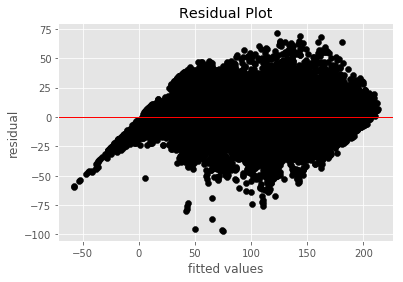

In [26]:
# Plotting the residual plot
# Residuals have been calculated by by substracting the test value from the predicted value
# 
residuals = np.subtract(y_pred, y_test)

# Plotting the residual scatterplot
#
plt.scatter(y_pred, residuals, color='black')
plt.title('Residual Plot')
plt.ylabel('residual')
plt.xlabel('fitted values')
plt.axhline(y = float(residuals.mean()), color='red', linewidth=1)
plt.show()

### Heteroskedasticity test using the barlett's test

In [29]:
# Performing the barlett's test
#
test_result, p_value = sp.stats.bartlett(y_pred.flatten(), np.array(list(residuals['rank'])))

# Calculating the critical value of the chi squared distribution, to compare it with the test_result
#
degrees_of_freedom = len(y_pred) - 1
probability =  1 - p_value
critical_value = sp.stats.chi2.ppf(probability, degrees_of_freedom)

# If the test_result is greater than the critical value, then the null hypothesis is
# rejected. This means that there are patterns to the variance of the data

# Otherwise, if no patterns are identified, null hypothesis is accepted. This means that 
# the variance is homogeneous across the dataset

if (test_result > critical_value):
  print(f'The test result of {np.round(test_result,2)} is greater than the critical value of {np.round(critical_value, 2)}')
  print('Thefore the variances are unequal, which means that the model should be reassessed')
  print('The variances are heterogenous')
else:
  print(f'The test result of {np.round(test_result,2)} is less than the critical value of {np.round(critical_value, 2)}')
  print('Thefore the variances are equal, which means that the model is okey. No need to reasses')
  print('The variances are homogeneous')

The test result of 15219.29 is less than the critical value of inf
Thefore the variances are equal, which means that the model is okey. No need to reasses
The variances are homogeneous


## Lasso Regresion

### Creating the model

In [31]:
# Creating X and y variables
#
X = ranking.drop(['rank', 'country_abrv', 'rank_date'], axis = 1)
y = ranking.iloc[:, 0:1]

# Encoding categorical variables
#
X = pd.get_dummies(X, drop_first=True)

# Splitting the dataset into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)

# Training the model
#
lasso = Lasso(normalize=True)
lasso.fit(X_train, y_train)

# Making predictions
#
y_pred = lasso.predict(X_test)

# Measuring the accuracy of the model
#
print(f'RMSE of Lasso: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Mean of y: {y.mean()[0]}')

RMSE of Lasso: 58.50662595010672
Mean of y: 101.61811759817162


*The model has a RMSE of 58 which is far bigger than 10% of the targets mean of 101. Therefore the model is not as good*

### Hyperparameter tuning to find the optimal parameters for the model

In [32]:
# Tuning the alpha parameter
# Creating a parameters dictionary
#
params = {'alpha': np.logspace(-5, 2, 8)}

# Creating a cross validation of 10 folds
#
kfold = KFold(n_splits = 10)

# Using grid search to find the optimal parameters
#
grid_search = GridSearchCV(estimator=Lasso(normalize = True), param_grid = params, cv = kfold, scoring = 'neg_mean_squared_error')

# Fitting the grid search 
#
grid_search_results = grid_search.fit(X, y)

# Displaying the best parameters and the the best score
#
print(f'Best score is {np.sqrt(grid_search.best_score_*-1)} and the best parameters are {grid_search.best_params_}')

Best score is 20.629828651565155 and the best parameters are {'alpha': 1e-05}


### Training the model with optimal parameters

In [33]:
# Training the model with the optimal alpha value
#
lasso = Lasso(normalize=True, alpha = 1e-05)
lasso.fit(X_train, y_train)

# Making predictions
#
y_pred = lasso.predict(X_test)

# Measuring the accuracy of the model
#
print(f'RMSE of Ridge: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Mean of y: {y.mean()[0]}')

RMSE of Ridge: 18.25938572210643
Mean of y: 101.61811759817162


*There is no performance difference between Ridge Regression and Lasso Regression*

### Performing cross validation to check for overfitting or underfitting

In [34]:
# Performing cross validation of ten folds
#
scores = cross_val_score(lasso, X, y, scoring = 'neg_mean_squared_error', cv = 10)

# Calculating the mean of the cross validation scores
#
print(f'Mean of cross validation scores is {np.sqrt(np.round(scores.mean()*-1, 3))}')

# Calculating the variance of the cross validation scores from the mean
#
print(f'Standard deviation of the cross validation scores is {np.round(scores.std(), 3)}')

Mean of cross validation scores is 20.62976005677235
Standard deviation of the cross validation scores is 185.671


*The standard deviation of Lasso Regression is more than that of Ridge Regression, therefore Lasso Regression is a bit worse off than Ridge Regression in making predictions*

### Heteroskedasticity test using the barlett's test

In [47]:
# Performing the barlett's test
#
test_result, p_value = sp.stats.bartlett(y_pred.flatten(), np.array(list(residuals['rank'])))

# Calculating the critical value of the chi squared distribution, to compare it with the test_result
#
degrees_of_freedom = len(y_pred) - 1
probability =  1 - p_value
critical_value = sp.stats.chi2.ppf(probability, degrees_of_freedom)

# If the test_result is greater than the critical value, then the null hypothesis is
# rejected. This means that there are patterns to the variance of the data

# Otherwise, if no patterns are identified, null hypothesis is accepted. This means that 
# the variance is homogeneous across the dataset

if (test_result > critical_value):
  print(f'The test result of {np.round(test_result,2)} is greater than the critical value of {np.round(critical_value, 2)}')
  print('Thefore the variances are unequal, which means that the model should be reassessed')
  print('The variances are heterogenous')
else:
  print(f'The test result of {np.round(test_result,2)} is less than the critical value of {np.round(critical_value, 2)}')
  print('Thefore the variances are equal, which means that the model is okey. No need to reasses')
  print('The variances are homogeneous')

The test result of 15208.81 is less than the critical value of inf
Thefore the variances are equal, which means that the model is okey. No need to reasses
The variances are homogeneous


## Elastic Net

## Creating the model

In [10]:
# Creating X and y variables
#
X = ranking.drop(['rank', 'country_abrv', 'rank_date'], axis = 1)
y = ranking.iloc[:, 0:1]

# Encoding categorical variables
#
X = pd.get_dummies(X, drop_first=True)

# Splitting the dataset into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)

# Training the model
#
elastic = ElasticNet(normalize=True)
elastic.fit(X_train, y_train)

# Making predictions
#
y_pred = elastic.predict(X_test)

# Measuring the accuracy of the model
#
print(f'RMSE of ElasticNet: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Mean of y: {y.mean()[0]}')

RMSE of ElasticNet: 58.50662595010672
Mean of y: 101.61811759817162


*The model has a RMSE of 58 which is far bigger than 10% of the targets mean of 101. Therefore the model is not as good*
*The predictive power of ElasticNet Regression is the same as that of Lasso Regression*

### Hyperparameter tuning to find the optimal parameters for the model

In [75]:
# Tuning the alpha parameter
# Creating a parameters dictionary
#
params = {'alpha': np.logspace(-5, 2, 8),
         'l1_ratio':[.2,.4,.6,.8]}

# Creating a cross validation of 10 folds
#
kfold = KFold(n_splits = 10)

# Using grid search to find the optimal parameters
#
grid_search = GridSearchCV(estimator=ElasticNet(normalize = True), param_grid = params, cv = kfold, scoring = 'neg_mean_squared_error')

# Fitting the grid search 
#
grid_search_results = grid_search.fit(X, y)

# Displaying the best parameters and the the best score
#
print(f'Best score is {np.sqrt(grid_search.best_score_*-1)} and the best parameters are {grid_search.best_params_}')

Best score is 21.189600736679512 and the best parameters are {'alpha': 1e-05, 'l1_ratio': 0.8}


### Training the model with optimal parameters

In [76]:
# Training the model with the optimal alpha value
#
elastic = ElasticNet(normalize=True, alpha = 1e-05, l1_ratio = 0.8)
elastic.fit(X_train, y_train)

# Making predictions
#
y_pred = elastic.predict(X_test)

# Measuring the accuracy of the model
#
print(f'RMSE of ElasticNet: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Mean of y: {y.mean()[0]}')

RMSE of ElasticNet: 18.756354692352023
Mean of y: 101.61811759817162


*ElasticNet has the lowest RMSE when compared with both Lasso and Ridge.*

### Performing cross validation to check for overfitting or underfitting

In [77]:
# Performing cross validation of ten folds
#
scores = cross_val_score(elastic, X, y, scoring = 'neg_mean_squared_error', cv = 10)

# Calculating the mean of the cross validation scores
#
print(f'Mean of cross validation scores is {np.sqrt(np.round(scores.mean()*-1, 3))}')

# Calculating the variance of the cross validation scores from the mean
#
print(f'Standard deviation of the cross validation scores is {np.round(scores.std(), 3)}')

Mean of cross validation scores is 21.189431327904956
Standard deviation of the cross validation scores is 227.514


*The cross validation mean of 21 is higher than the model's 18, therefore generally the model's RMSE accuracy lies between 18 and 20. On the other hand, ElasticNet's standard deviation is quit high, therefore the model should be handled cautiously.
In terms of stability, ElasicNet Regression is worse off when compared with Lasso and Ridge Regression*

### Heteroskedasticity test using the barlett's test

In [81]:
# Performing the barlett's test
#
test_result, p_value = sp.stats.bartlett(y_pred.flatten(), np.array(list(residuals['rank'])))

# Calculating the critical value of the chi squared distribution, to compare it with the test_result
#
degrees_of_freedom = len(y_pred) - 1
probability =  1 - p_value
critical_value = sp.stats.chi2.ppf(probability, degrees_of_freedom)

# If the test_result is greater than the critical value, then the null hypothesis is
# rejected. This means that there are patterns to the variance of the data

# Otherwise, if no patterns are identified, null hypothesis is accepted. This means that 
# the variance is homogeneous across the dataset

if (test_result > critical_value):
  print(f'The test result of {np.round(test_result,2)} is greater than the critical value of {np.round(critical_value, 2)}')
  print('Thefore the variances are unequal, which means that the model should be reassessed')
  print('The variances are heterogenous')
else:
  print(f'The test result of {np.round(test_result,2)} is less than the critical value of {np.round(critical_value, 2)}')
  print('Thefore the variances are equal, which means that the model is okey. No need to reasses')
  print('The variances are homogeneous')

The test result of 14016.37 is less than the critical value of inf
Thefore the variances are equal, which means that the model is okey. No need to reasses
The variances are homogeneous


### Comparing coefficients of the three models

In [42]:
# Creating a dataframe to campare the coefficients of the three models
# Top 20 of the most important features in predicting the rank of a team.
#
pd.DataFrame({'feature': X.columns, 
              'lasso_coeff': lasso.coef_, 
              'ridge_coeff': ridge.coef_[0], 
              'elastic_coeff': elastic.coef_}).sort_values(by = 'elastic_coeff', ascending = False).head(20)

,feature,lasso_coeff,ridge_coeff,elastic_coeff
89,country_full_Gibraltar,79.728884,68.848393,78.676993
173,country_full_San Marino,70.042558,59.027985,70.866664
16,country_full_Andorra,65.363446,54.354912,66.556649
68,country_full_Djibouti,51.829701,50.905770,64.435608
185,country_full_Somalia,49.595449,48.664784,62.497709
35,country_full_Bhutan,22.222969,18.875831,60.851364
18,country_full_Anguilla,48.911643,44.764923,60.519828
92,country_full_Guam,20.808174,17.448524,59.735878
115,country_full_Kosovo,57.529856,46.637313,57.753038
204,country_full_Timor-Leste,18.208963,14.879957,56.879606


*ElasticNet Regression shrunks the coefficients of the features more than the Lasso and Ridge Regression models*

## Challenging the Solution

In [43]:
# Using other models to find the one with optimal accuracy
#
# Importing different classification models
#
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


# Creating a list of classifier algorithms to compare with
#
models = [RandomForestRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), DecisionTreeRegressor(),  XGBRegressor(),\
          SVR(), KNeighborsRegressor(), LinearRegression()]

# Creating lists of the algorithms, to store the accuracy scores of each fold
#
RandomForest, GradientBoosting, AdaBoost, DecisionTree, XGB, SVR, KNeighbors, Linear = ([] for x in range(8))

# Creating a list containig the list of each algorithm. Created for easy iteration
#
model_list = [RandomForest, GradientBoosting, AdaBoost, DecisionTree, XGB, SVR, KNeighbors, Linear]

# Spliting the data into features and the target variable
#
X = ranking.drop(['rank', 'country_abrv', 'rank_date'], axis = 1)
y = ranking.iloc[:, 0:1]

# Encoding categorical variables
#
X = pd.get_dummies(X, drop_first=True)

# Creating a cross validation of 10 folds
#
kfold  = KFold(n_splits=10, random_state=101)

# Iterating through each model and appending the scores of each fold to the appriopriate list
#
for i, j in zip(models, model_list):
  j.extend(list(cross_val_score(i, X, y, scoring = 'neg_mean_squared_error', cv = kfold)))
  
# Creating a function to convert neg_mean_squared_error to a square root
#
def sq(lis):
  new_lis = []
  lis = np.array(lis)
  for i in lis:
    i = np.sqrt(i*-1)
    new_lis.append(i)
  return new_lis
     
# Creating a dataframe of all the scores from the iterations for each model
#
scores = pd.DataFrame({'RandomForest': sq(RandomForest), 'GradientBoosting': sq(GradientBoosting), 'Adaboost': sq(AdaBoost), 'DecisionTree': sq(DecisionTree),\
                       'XGB': sq(XGB), 'SVR': sq(SVR), 'Kneighbors': sq(KNeighbors), 'Linear': sq(Linear)})

# Calculating the mean and standard deviation score of each algorithm
#
scores.loc['mean'] = scores.mean()
scores.loc['std'] = scores.std()

# Previewing the scores dataframe
#
scores

[09:10:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,RandomForest,GradientBoosting,Adaboost,DecisionTree,XGB,SVR,Kneighbors,Linear
0,22.654163,24.636967,38.845324,22.137324,24.458236,14.198456,24.776852,1.186224e+02
1,65.438264,61.656325,46.950831,65.402754,62.270278,25.742648,31.025332,2.356753e+01
2,11.910598,16.458796,25.968875,12.054190,9.598867,26.125025,22.501108,1.835295e+01
3,6.804869,7.867413,21.831397,7.356405,8.068631,19.230697,7.960524,1.767945e+01
4,14.593088,14.306151,24.835276,14.758830,19.714378,21.140448,14.821507,1.743831e+01
5,13.558312,11.828807,20.201187,14.337970,12.210678,25.373895,15.035454,1.753270e+01
6,7.102412,9.332435,20.015816,7.531395,9.260838,25.478397,6.185074,1.698266e+01
7,5.914902,5.880359,17.387415,7.180047,5.794002,56.815372,5.101335,1.811385e+01
8,5.574105,5.847157,19.750586,6.194789,5.792323,57.261565,5.658508,1.992196e+01
9,4.646808,6.677881,23.868683,5.690472,6.620835,57.712161,5.855444,2.159950e+07


In [84]:
# Using Kneighbors regressor to make predictions
#
neiba = KNeighborsRegressor()
neiba.fit(X_train, y_train)

# Making predictions
#
y_pred = neiba.predict(X_test)

# Measuring the accuracy of the model
#
print(f'RMSE of KNeighbors: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Mean of y: {y.mean()[0]}')

RMSE of KNeighbors: 7.570265444500665
Mean of y: 101.61811759817162


In [85]:
# Tuning the alpha parameter
# Creating a parameters dictionary
#
params = {'n_neighbors': [2, 5, 7, 9],
         'leaf_size': [20, 30, 40],
         'p': [1, 2, 3, 5]}

# Creating a cross validation of 10 folds
#
kfold = KFold(n_splits = 10)

# Using grid search to find the optimal parameters
#
grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid = params, cv = kfold, scoring = 'neg_mean_squared_error')

# Fitting the grid search 
#
grid_search_results = grid_search.fit(X, y)

# Displaying the best parameters and the the best score
#
print(f'Best score is {np.sqrt(grid_search.best_score_*-1)} and the best parameters are {grid_search.best_params_}')

Best score is 15.515858937318763 and the best parameters are {'leaf_size': 20, 'n_neighbors': 9, 'p': 1}


In [11]:
# Using Kneighbors regressor to make predictions
#
neiba = KNeighborsRegressor(leaf_size=20, n_neighbors=9, p = 1)
neiba.fit(X_train, y_train)

# Making predictions
#
y_pred = neiba.predict(X_test)

# Measuring the accuracy of the model
#
print(f'RMSE of KNeighbors: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Mean of y: {y.mean()[0]}')

RMSE of KNeighbors: 7.121168789764826
Mean of y: 101.61811759817162


*The models accuracy has improved from 7.5 to 7.12*

## Conclusion

*The Kneighbors regressor model gives the highest accuracy and is the most stable when compared with the other regressors*